## Green-Plant Management GmbH - Deforastation Management
### Step 0 - Registration
Please [register](https://console.up42.com/register) for the UP42 platform and
review and [accept the end-user license agreement](https://docs.up42.com/getting-started/account/eulas) (EULA). 

### Step 1 - Installation
Install the required packages on your local machine (see [documentation](https://sdk.up42.com/)) through the console

```
pip install up42-py
```

a python version > 3.8 is required. 

### Step 2 - Authentication
First please create a authentication file named 'credentials.json' which contains your **UP42 credentials** as follows

```json
{
    "username" : "<your-email-address>",
    "password" : "<your-password>"
}
```


In [1]:
# Module Imports
import os
import sys
import rasterio
import numpy as np
import up42

# Authentication
up42.authenticate(cfg_file="credentials.json")

2023-12-14 21:59:55,326 - Got credentials from config file.
2023-12-14 21:59:58,101 - Authentication with UP42 successful!


### Step 3 - Choose the tasking collection
Get the Sentinel-2 collection `data_product_id` for ordering.

In [2]:
catalog = up42.initialize_catalog()
data_product_id = catalog.get_data_products(basic=True).get("Sentinel-2").get("data_products").get("Level-2A")

data_products = catalog.get_data_products(basic=True) # dictionary of all data products
catalog.get_data_product_schema(data_product_id) # print out the required parameters

{'$schema': 'https://json-schema.org/draft-07/schema',
 'type': 'object',
 'properties': {'id': {'title': 'Id', 'type': 'string'}},
 'required': ['id'],
 'definitions': None,
 'additionalProperties': False,
 'title': 'EarthSearchAwsParams'}

### Step 4 - Fill Out an Order Form
Retrieve Geometry from `GeoJSON`

In [3]:
geometry = up42.read_vector_file("data/amazonas.geojson") # examplatory AOI file

and search catalog for data from beginning of observation period (`start_date`) until end of observation period (`end_date`)

In [4]:
search_results = catalog.search(search_parameters=catalog.construct_search_parameters(
    geometry= geometry,
    start_date="2017-12-01", end_date="2023-11-30",
    collections=[data_products.get("Sentinel-2").get("collection")],
    max_cloudcover=5, limit=500)) # Cloudcover threshold kept low at 5% 

2023-12-14 22:01:08,639 - Searching catalog with search_parameters: {'datetime': '2017-12-01T00:00:00Z/2023-11-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-55.80602463366668, -13.267580954511516), (-55.80602463366668, -13.49938970772358), (-55.520612343249226, -13.49938970772358), (-55.520612343249226, -13.267580954511516), (-55.80602463366668, -13.267580954511516)),)}, 'limit': 500, 'collections': ['sentinel-2'], 'query': {'cloudCoverage': {'lte': 5}}}
2023-12-14 22:01:17,038 - 158 results returned.


#### 4.1 - Folder Setup
Create a folder structure for better data structure. This is not directly related to the **UP42** pipeline.

In [20]:
# Setup a directory for local storage 
output_directory = os.getcwd() + "/quicklook/" # set output directory

if os.path.exists(output_directory): # remove old files if they exists
    for file in os.listdir(output_directory):
         file_path = os.path.join(output_directory, file)
         os.remove(file_path)

#### 4.2 - Quicklook of queried images
In our case we download and `quicklook` at the earliest and the latest image in our timeseries.

In [21]:
# Get identifier for specific images in catalog

# select earliest image and latest image from search
# image_ids = [list(search_results.id)[-1], 
#              list(search_results.id)[0]]  

# select multiple images
image_ids = [list(search_results.id)[-1],                          # earliest scene       
             list(search_results.id)[len(search_results.id)//2],   # scene at around half of observation period
             list(search_results.id)[0]]                           # latest scene 

# Download quicklooks
catalog.download_quicklooks(
    image_ids= image_ids, 
    collection=data_products.get("Sentinel-2").get("collection"),
    output_directory = output_directory,
)

2023-12-14 22:15:07,138 - Downloading quicklooks from provider earthsearch-aws.
2023-12-14 22:15:07,142 - Download directory: C:\Users\Jacob\Documents\CODE\up42\tse_challenge\quicklook
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.13s/it]


['C:\\Users\\Jacob\\Documents\\CODE\\up42\\tse_challenge\\quicklook\\quicklook_S2A_21LXF_20180303_0_L2A.jpg',
 'C:\\Users\\Jacob\\Documents\\CODE\\up42\\tse_challenge\\quicklook\\quicklook_S2B_21LXF_20200913_1_L2A.jpg',
 'C:\\Users\\Jacob\\Documents\\CODE\\up42\\tse_challenge\\quicklook\\quicklook_S2A_21LXF_20230913_0_L2A.jpg']

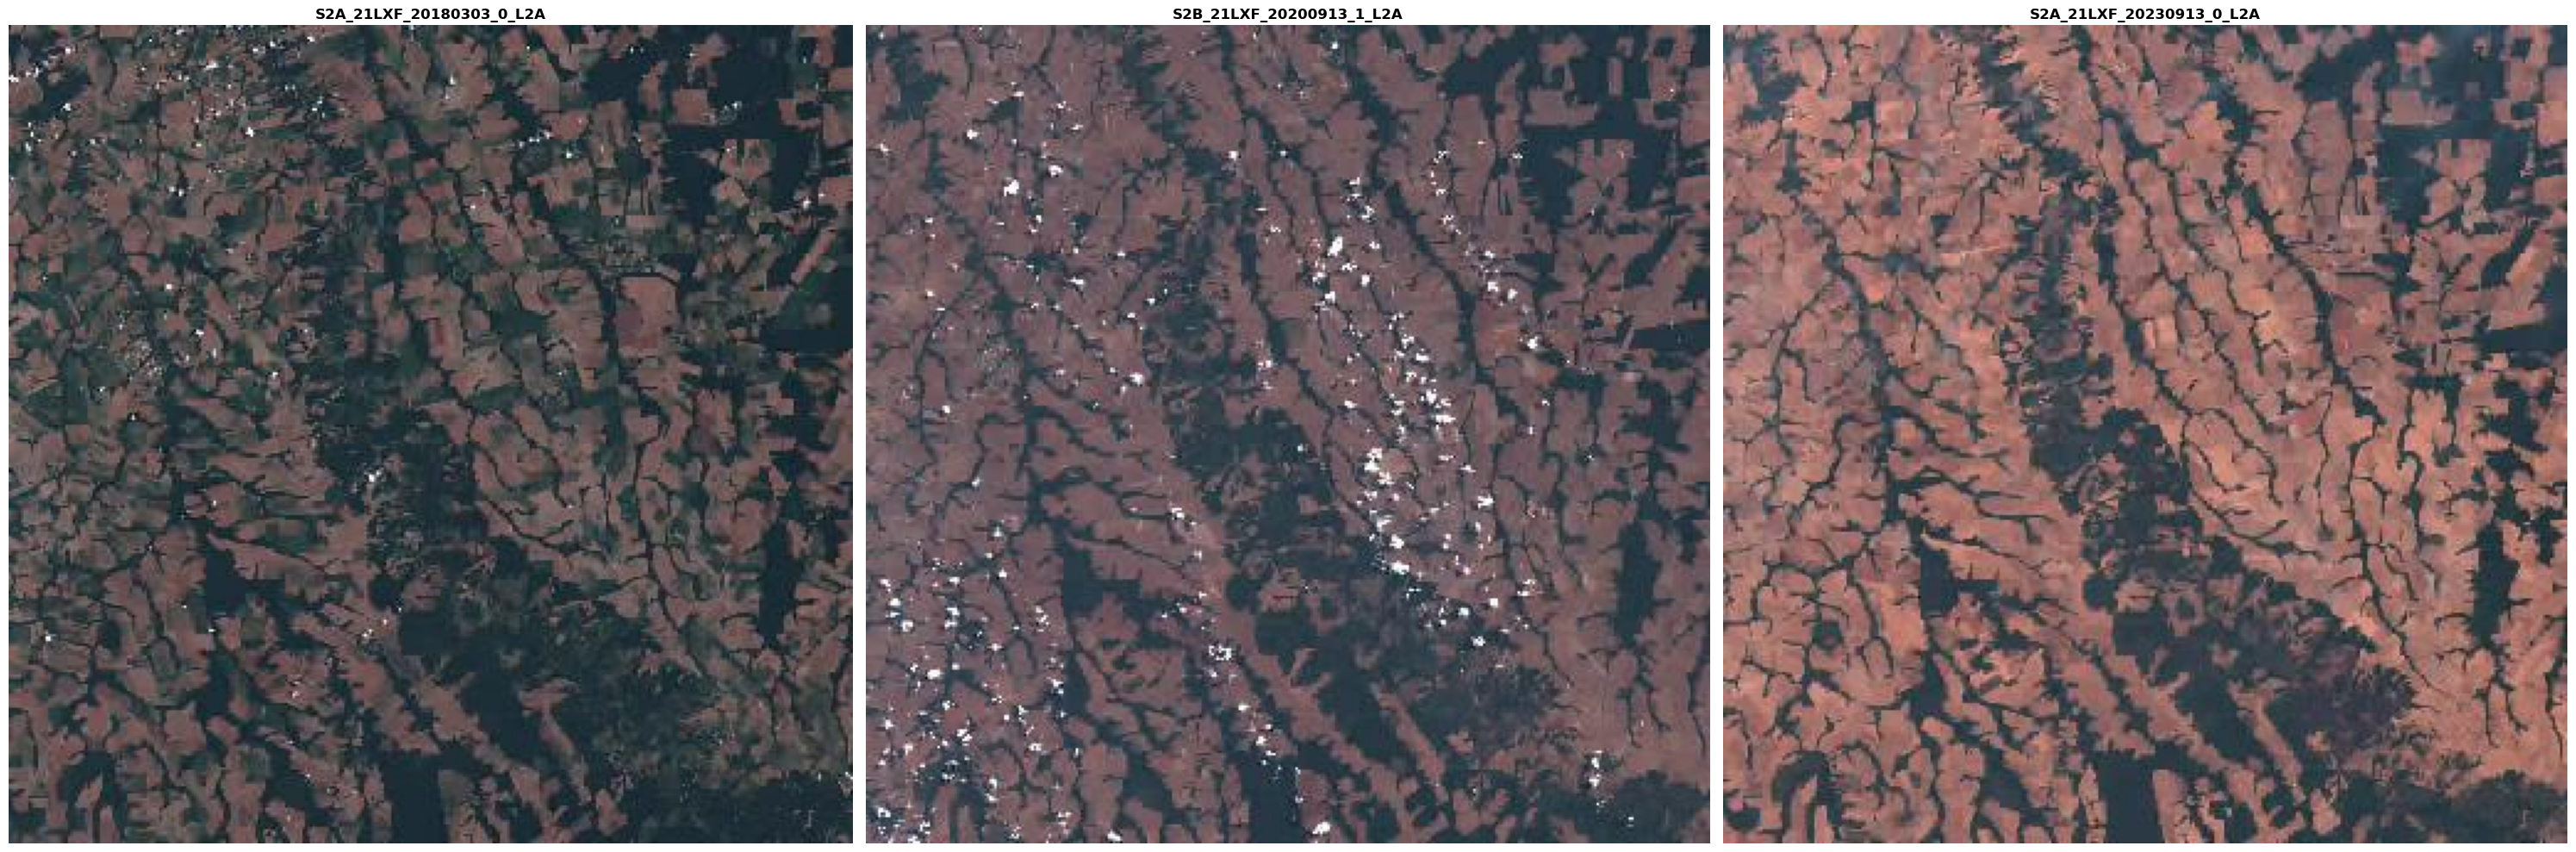

In [23]:
# Plot quicklooks
catalog.plot_quicklooks(
    figsize=(30, 10),
    filepaths = [os.path.join(output_directory, file) for file in os.listdir(output_directory)],
    titles= image_ids, # Images titled according to sentinel 2 terminology
)

### Step 5 - Place and track the order of the selected scenes

In [24]:
order_id_dict = {} # dictionary to keep track of unique ids

# run odering process for all selected images
for image_id in image_ids:
    order_parameters = catalog.construct_order_parameters(           # build order parameters
        data_product_id=data_product_id, image_id=image_id) 
    catalog.estimate_order(order_parameters)                         # get UP42 cost estimation
    order = catalog.place_order(order_parameters, track_status=True) # place order into cloudservice
    order_id_dict[image_id] = order.order_id

2023-12-14 22:16:25,135 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.
2023-12-14 22:16:29,980 - Order is estimated to cost 0 UP42 credits (order_parameters: {'dataProduct': 'c3de9ed8-f6e5-4bb5-a157-f6430ba756da', 'params': {'id': 'S2A_21LXF_20180303_0_L2A'}})
2023-12-14 22:16:35,047 - Order is PLACED
2023-12-14 22:16:35,047 - Order 059638c1-c7ce-4a91-85b6-168676b7ff0b is now PLACED.
2023-12-14 22:16:35,048 - Tracking order status, reporting every 120 seconds...
2023-12-14 22:16:36,285 - Order is PLACED
2023-12-14 22:16:37,366 - Order is PLACED
2023-12-14 22:18:40,236 - Order is BEING_FULFILLED
2023-12-14 22:18:41,874 - Order is BEING_FULFILLED
2023-12-14 22:18:43,586 - Order is BEING_FULFILLED! - 059638c1-c7ce-4a91-85b6-168676b7ff0b
2023-12-14 22:18:43,587 - 
2023-12-14 22:20:49,205 - Order is FULFILLED
2023-12-14 22:20:49,207 - Order is fulfilled successfully! - 059638c1-c7ce-4a91-85b6-168676b7ff0b
2023-12-14 22:20:50,644 - Order is

### Step 6 - Download the required assets
After the order have been `PLACED` and `FULFILLED` the requested Scenes are ready for download

for our use case the Sentinel 2 bands `band 4` (red) and `band 8` (NIR) are sufficient as NDVI is calculated as
`NIR(Band8)-Red(Band4)} / {NIR(Band8)+Red(Band4)`

Downloaded bands `.tif` are stored in subfolders located in the folder `/assets` according to sentinel 2 terminology.

In [27]:
for image_id in image_ids:
    order_id = order_id_dict[image_id]
    asset_directory = os.getcwd() + '/assets/' + image_id # Setup directory for local storage
    asset = up42.initialize_order(order_id=order_id).get_assets()[0] 
    stac_items = asset.stac_items                         # get STAC items within order

    # download NIR band asset
    asset.download_stac_asset( 
        stac_asset=asset.stac_items.items[0].assets.get("b08.tiff"),
        output_directory= asset_directory,
    )

    # download Red band asset
    asset.download_stac_asset(
        stac_asset=asset.stac_items.items[0].assets.get("b04.tiff"),
        output_directory= asset_directory,
    )

2023-12-14 22:48:53,976 - Initialized Order(order_id: 059638c1-c7ce-4a91-85b6-168676b7ff0b, assets: ['b0df6a81-c111-4d8f-b2eb-1661f56072fb'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-14T21:16:31.839294Z, updatedAt: 2023-12-14T21:20:38.256843Z)
2023-12-14 22:48:55,036 - Order is FULFILLED
2023-12-14 22:49:08,749 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-14 22:49:08,750 - Download directory: C:\Users\Jacob\Documents\CODE\up42\tse_challenge\assets\S2A_21LXF_20180303_0_L2A
216929it [00:32, 6734.32it/s]
2023-12-14 22:49:43,281 - Successfully downloaded the file at C:\Users\Jacob\Documents\CODE\up42\tse_challenge\assets\S2A_21LXF_20180303_0_L2A\b08.tiff
2023-12-14 22:49:49,265 - Downloading STAC asset Red (band 4) - 10m
2023-12-14 22:49:49,267 - Download directory: C:\Users\Jacob\Documents\CODE\up42\tse_challenge\assets\S2A_21LXF_20180303_0_L2A
206110it [00:30, 6852.57it/s]
2023-12-14 22:50:21,612 - Successfully downloaded the file at C:\Users\Jacob\Documents\COD

### Step 7 - Calculate NDVI of individual images
From our downloaded spectral bands we can now derive the NDVI. Through the use of `rasterio` we open the `.tif` into a `np.array`.
After calculating the NDVI we can store the `np.array` raster data back on disk. For this we duplicate the extent and metadata from on original band into the new `ndvi.tif`.

In [28]:
for image_id in image_ids: # run for all selected images
    asset_directory = os.getcwd() + '/assets/' + image_id # Setup directory for local storage
    
    # import bands into numpy array through rasterio
    red  = rasterio.open(asset_directory + '/' + "b04.tiff").read(1).astype('float64')
    nir = rasterio.open(asset_directory + '/' + "b08.tiff").read(1).astype('float64')

    # calculate NDVI raster
    ndvi=np.where( (nir+red)==0., 0, (nir-red)/(nir+red) ) # It will return 0 for No Data value

    # save .tif to /assets folder
    b4data = rasterio.open(asset_directory + '/' + "b04.tiff")
    ndviTiff = rasterio.open(asset_directory + '/' + '/ndvi.tiff','w',driver='Gtiff',
                              width = b4data.width, 
                              height = b4data.height, 
                              count=1, crs=b4data.crs, 
                              transform=b4data.transform, 
                              dtype='float64')
    ndviTiff.write(ndvi,1)
    ndviTiff.close()

In [29]:
image_ids

['S2A_21LXF_20180303_0_L2A',
 'S2B_21LXF_20200913_1_L2A',
 'S2A_21LXF_20230913_0_L2A']

### Step 8 - Calculate NDVI differences between timesteps
After selecting two images from our pre-selection (`image_ids`) we can again open the files and use the `numpy` arithmetic operations to get the difference in NDVI.

In [30]:
# select which assets should be used for analysis of NDVI differences
# default is the first and last image that were ordered
ndvi_image_id_1 = image_ids[0] # earliest img
ndvi_image_id_2 = image_ids[-1] # latest img 

# alternatively you could directly specify which image from the search results should be used manually
#print(image_ids)
#ndvi_image_id_1 = 'S2A_21LXF_20180303_0_L2A'
#ndvi_image_id_2 = 'S2A_21LXF_20230913_0_L2A'

# read NDVI.tiff images
ndvi1 = rasterio.open( os.getcwd() + '/assets/' + ndvi_image_id_1 +  '/ndvi.tiff').read(1)
ndvi2 = rasterio.open( os.getcwd() + '/assets/' + ndvi_image_id_2 +  '/ndvi.tiff').read(1)

# difference calculation
ndvi_diff = ndvi2 - ndvi1

In [32]:
# Save differences in NDVI to file
ndviDiffTiff_path = os.getcwd() + '/assets/' + 'ndvidiff.tiff'
ndviDiffTiff = rasterio.open(ndviDiffTiff_path,'w',driver='Gtiff',
                          width = b4data.width, # uses metadata of orginal image
                          height = b4data.height, 
                          count=1, crs=b4data.crs, 
                          transform=b4data.transform, 
                          dtype='float64')
ndviDiffTiff.write(ndvi_diff,1)
ndviDiffTiff.close()

### Step 9 - Visualize the difference in NDVI
For the first and second image: Areas with high NDVI values are displayed in dark green while areas with lower NDVI values are displayed in lighter green and yellow colors.

For the third image : Areas were NDVI has increased between observations shown in darker green while areas which have decreased are shown in reddish colors. 

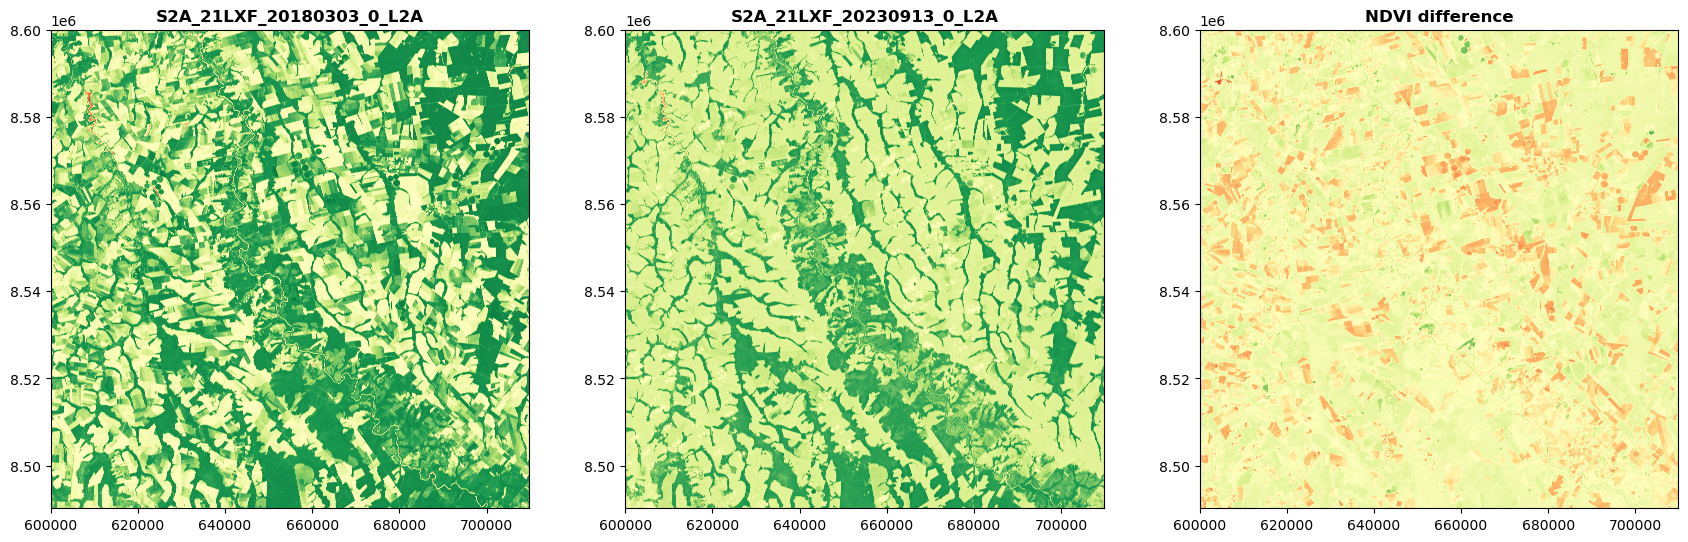

In [40]:
# some more packages are required for the visualisation
from rasterio.plot import show
from matplotlib import pyplot as plt

# get the .tif to be plotted
src1 = rasterio.open(os.getcwd() + '/assets/' + ndvi_image_id_1 +  '/ndvi.tiff')
src2 = rasterio.open(os.getcwd() + '/assets/' + ndvi_image_id_2 +  '/ndvi.tiff')
src3 = rasterio.open(ndviDiffTiff_path)

# Plot
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((src1, 1), ax=axr, cmap='RdYlGn', title= ndvi_image_id_1 )
show((src2, 1), ax=axg, cmap='RdYlGn', title= ndvi_image_id_2 )
show((src3, 1), ax=axb, cmap='RdYlGn', title='NDVI difference')
plt.show()

### Step 10 - The way forward
Obviously time steps and image selection will be up to you and logging events might be best detected right after the clearing to get the highest contrast. Depending on what you would like to achieve it would be possible to define a threshold of NDVI differences which marks the difference between natural vegetation and logged areas. Regardless I hope this small code bit can be a first letch off point for further analysis. 